In [47]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional, Embedding, Dropout, Dense, Input, Attention, GlobalAveragePooling1D
nltk.download('stopwords')

import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\b\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# Spécifiez le chemin du fichier
train = pd.read_csv("train.csv")

In [49]:
train.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [50]:
# Suppression des valeurs manquante
df = train.dropna()

In [51]:
X = df.drop("label", axis = 1)
X.shape

y = df["label"]
y.shape

(18285,)

In [52]:
messages=X.copy()
messages.reset_index(inplace=True)

In [53]:
# Stemming : 
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [54]:
voc = 10000
onehot_repr=[one_hot(words,voc)for words in corpus] 

In [55]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [56]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

X_final.shape,y_final.shape

((18285, 20), (18285,))

In [57]:
# Fractionner les données (Train, Test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [58]:
# Modèle 1 : RNN

embedding_vector_features=40

rnn = Sequential()
rnn.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
rnn.add(SimpleRNN(100,return_sequences=False))
rnn.add(Dense(1, activation='sigmoid'))

rnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 40)            400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               14100     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 414,201
Trainable params: 414,201
Non-trainable params: 0
_________________________________________________________________


In [59]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = rnn.fit(X_train, y_train,epochs=20,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/20
458/458 [==============================] - 20s 42ms/step - loss: 0.2580 - accuracy: 0.8895 - val_loss: 0.2145 - val_accuracy: 0.9098
Epoch 2/20
458/458 [==============================] - 19s 42ms/step - loss: 0.0823 - accuracy: 0.9688 - val_loss: 0.2515 - val_accuracy: 0.9027
Epoch 3/20
458/458 [==============================] - 19s 42ms/step - loss: 0.0182 - accuracy: 0.9950 - val_loss: 0.3265 - val_accuracy: 0.9040
Epoch 4/20
458/458 [==============================] - 19s 42ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.4214 - val_accuracy: 0.9098
Epoch 5/20
458/458 [==============================] - 19s 42ms/step - loss: 5.6960e-04 - accuracy: 0.9999 - val_loss: 0.4350 - val_accuracy: 0.9081
Epoch 6/20
458/458 [==============================] - 19s 42ms/step - loss: 1.4420e-04 - accuracy: 1.0000 - val_loss: 0.4622 - val_accuracy: 0.9117
Epoch 7/20
458/458 [==============================] - 19s 42ms/step - loss: 7.8755e-05 - accuracy: 1.0000 - val_loss: 0.4766 - v

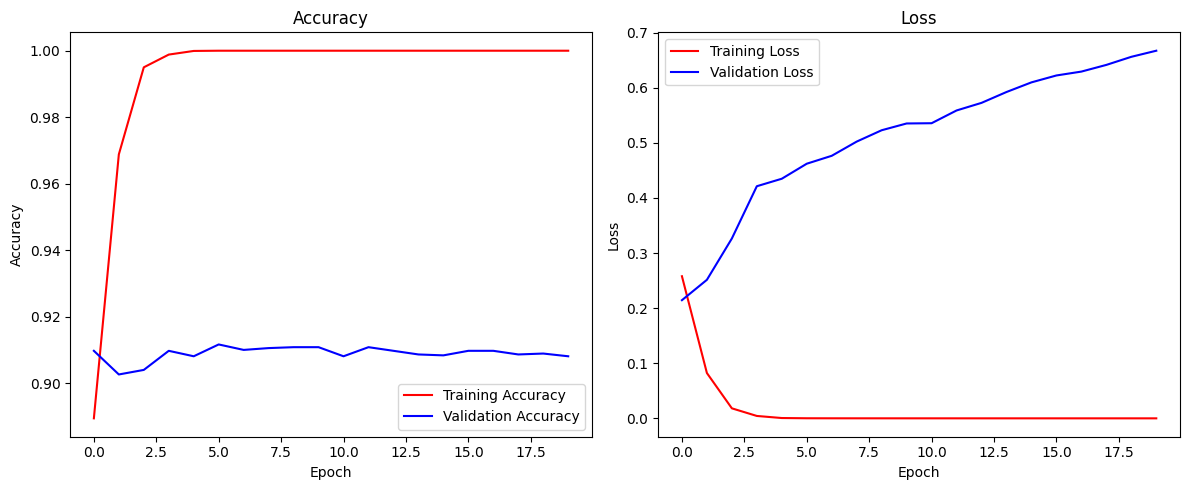

In [60]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="red")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()  
plt.show()

In [61]:
# Evaluation :
y_rnn=rnn.predict(X_test)
y_rnn = (y_rnn>0.5).astype(int)

115/115 [==============================] - 1s 8ms/step


In [63]:
# Accuracy du RNN
accuracy_score(y_test,y_rnn)

0.9081214109926169

In [64]:
confusion_matrix(y_test,y_rnn)

array([[1860,  222],
       [ 114, 1461]], dtype=int64)

In [65]:
print(classification_report(y_test,y_rnn))


              precision    recall  f1-score   support

           0       0.94      0.89      0.92      2082
           1       0.87      0.93      0.90      1575

    accuracy                           0.91      3657
   macro avg       0.91      0.91      0.91      3657
weighted avg       0.91      0.91      0.91      3657



In [66]:
# Modèle 2 : LSTM

embedding_vector_features=40

lstm=Sequential()
lstm.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
lstm.add(Dropout(0.3))
lstm.add(LSTM(100))
lstm.add(Dropout(0.3))
lstm.add(Dense(1,activation='sigmoid'))

lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 40)            400000    
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________


In [67]:
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
458/458 [==============================] - 8s 10ms/step - loss: 0.2682 - accuracy: 0.8773 - val_loss: 0.1936 - val_accuracy: 0.9141
Epoch 2/20
458/458 [==============================] - 4s 9ms/step - loss: 0.1342 - accuracy: 0.9474 - val_loss: 0.2209 - val_accuracy: 0.9114
Epoch 3/20
458/458 [==============================] - 4s 9ms/step - loss: 0.0916 - accuracy: 0.9643 - val_loss: 0.2388 - val_accuracy: 0.9114
Epoch 4/20
458/458 [==============================] - 4s 9ms/step - loss: 0.0640 - accuracy: 0.9774 - val_loss: 0.2639 - val_accuracy: 0.9098
Epoch 5/20
458/458 [==============================] - 4s 9ms/step - loss: 0.0436 - accuracy: 0.9850 - val_loss: 0.3114 - val_accuracy: 0.9119
Epoch 6/20
458/458 [==============================] - 4s 9ms/step - loss: 0.0298 - accuracy: 0.9898 - val_loss: 0.4182 - val_accuracy: 0.9122
Epoch 7/20
458/458 [==============================] - 4s 9ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.3721 - val_accuracy: 0.9114
Epoch

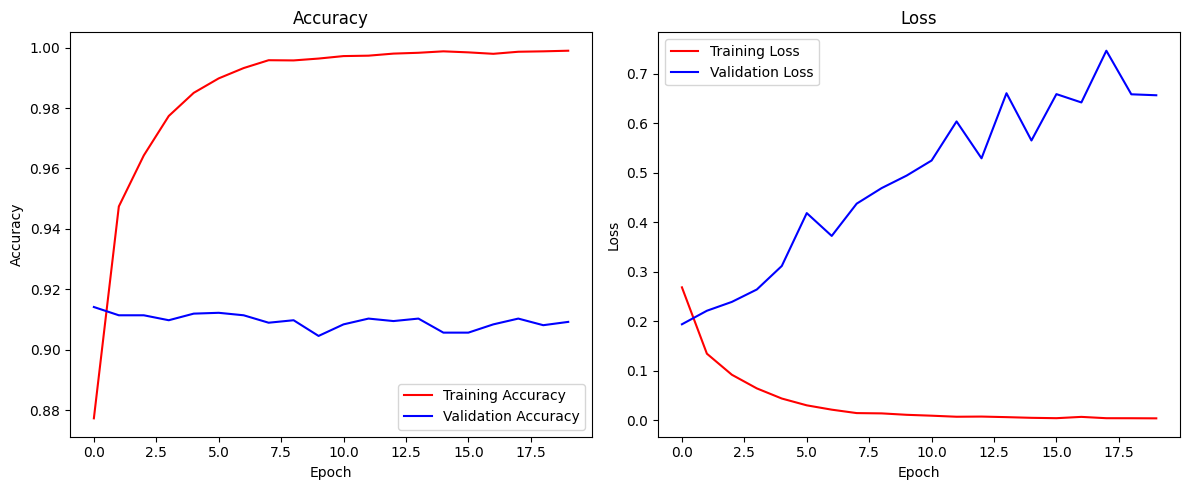

In [68]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="red")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()  
plt.show()

In [69]:
# Evaluation :
y_lstm=lstm.predict(X_test)
y_lstm = (y_lstm>0.5).astype(int)

115/115 [==============================] - 1s 6ms/step


In [70]:
accuracy_score(y_test,y_lstm)

0.9092152037188953

In [71]:
confusion_matrix(y_test,y_lstm)

array([[1876,  206],
       [ 126, 1449]], dtype=int64)

In [72]:
print(classification_report(y_test,y_lstm))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2082
           1       0.88      0.92      0.90      1575

    accuracy                           0.91      3657
   macro avg       0.91      0.91      0.91      3657
weighted avg       0.91      0.91      0.91      3657



In [73]:
# Modèle 3 : Bidirectional LSTM

embedding_vector_features=40

bid=Sequential()
bid.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
bid.add(Bidirectional(LSTM(100)))
bid.add(Dropout(0.3))
bid.add(Dense(1,activation='sigmoid'))

bid.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 20, 40)            400000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              112800    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 201       
                                                                 
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________


In [74]:
bid.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = bid.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
458/458 [==============================] - 9s 14ms/step - loss: 0.2522 - accuracy: 0.8873 - val_loss: 0.2086 - val_accuracy: 0.9128
Epoch 2/20
458/458 [==============================] - 5s 12ms/step - loss: 0.1185 - accuracy: 0.9549 - val_loss: 0.2196 - val_accuracy: 0.9128
Epoch 3/20
458/458 [==============================] - 5s 12ms/step - loss: 0.0741 - accuracy: 0.9738 - val_loss: 0.2698 - val_accuracy: 0.9073
Epoch 4/20
458/458 [==============================] - 5s 11ms/step - loss: 0.0464 - accuracy: 0.9843 - val_loss: 0.3553 - val_accuracy: 0.9062
Epoch 5/20
458/458 [==============================] - 5s 11ms/step - loss: 0.0280 - accuracy: 0.9906 - val_loss: 0.4088 - val_accuracy: 0.9051
Epoch 6/20
458/458 [==============================] - 5s 12ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.4898 - val_accuracy: 0.9057
Epoch 7/20
458/458 [==============================] - 5s 12ms/step - loss: 0.0143 - accuracy: 0.9947 - val_loss: 0.4509 - val_accuracy: 0.9048

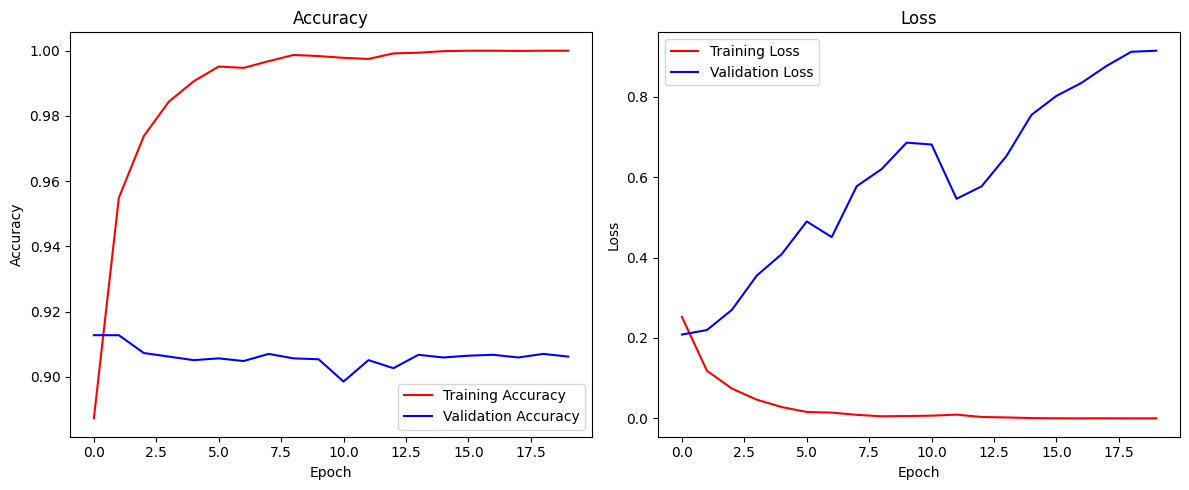

In [75]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="red")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()  
plt.show()


In [76]:
# Evaluation :
y_bid=bid.predict(X_test)
y_bid = (y_bid>0.5).astype(int)

115/115 [==============================] - 1s 6ms/step


In [77]:
accuracy_score(y_test,y_bid)

0.9062072737216298

In [78]:
confusion_matrix(y_test,y_bid)

array([[1888,  194],
       [ 149, 1426]], dtype=int64)

In [79]:
print(classification_report(y_test,y_bid))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2082
           1       0.88      0.91      0.89      1575

    accuracy                           0.91      3657
   macro avg       0.90      0.91      0.90      3657
weighted avg       0.91      0.91      0.91      3657



In [80]:
# Modèle 4 : Transformer

embedding_vector_features = 40
num_heads = 2  # Nombre de têtes d'attention
ff_dim = 32  # Dimension de la couche de feed-forward

inputs = Input(shape=(sent_length,))
embedding = Embedding(input_dim=voc, output_dim=embedding_vector_features, input_length=sent_length)(inputs)

# Transformer
attention = Attention(use_scale=True)([embedding, embedding])
transformer = GlobalAveragePooling1D()(attention)
ff = Dense(ff_dim, activation='relu')(transformer)
outputs = Dense(1, activation='sigmoid')(ff)
transformer_model = Model(inputs=inputs, outputs=outputs)

transformer_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 20, 40)       400000      ['input_13[0][0]']               
                                                                                                  
 attention_12 (Attention)       (None, 20, 40)       1           ['embedding_15[0][0]',           
                                                                  'embedding_15[0][0]']           
                                                                                                  
 global_average_pooling1d_10 (G  (None, 40)          0           ['attention_12[0][0]']     

__________________________________________________________________________________________________


In [81]:
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])
history = transformer_model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
458/458 [==============================] - 5s 9ms/step - loss: 0.3529 - accuracy: 0.8389 - val_loss: 0.2034 - val_accuracy: 0.9100
Epoch 2/20
458/458 [==============================] - 4s 8ms/step - loss: 0.1453 - accuracy: 0.9439 - val_loss: 0.1983 - val_accuracy: 0.9152
Epoch 3/20
458/458 [==============================] - 3s 7ms/step - loss: 0.1024 - accuracy: 0.9635 - val_loss: 0.2205 - val_accuracy: 0.9150
Epoch 4/20
458/458 [==============================] - 3s 8ms/step - loss: 0.0768 - accuracy: 0.9744 - val_loss: 0.2486 - val_accuracy: 0.9128
Epoch 5/20
458/458 [==============================] - 4s 8ms/step - loss: 0.0594 - accuracy: 0.9818 - val_loss: 0.2773 - val_accuracy: 0.9128
Epoch 6/20
458/458 [==============================] - 3s 7ms/step - loss: 0.0462 - accuracy: 0.9868 - val_loss: 0.3116 - val_accuracy: 0.9089
Epoch 7/20
458/458 [==============================] - 4s 8ms/step - loss: 0.0372 - accuracy: 0.9903 - val_loss: 0.3525 - val_accuracy: 0.9059
Epoch 

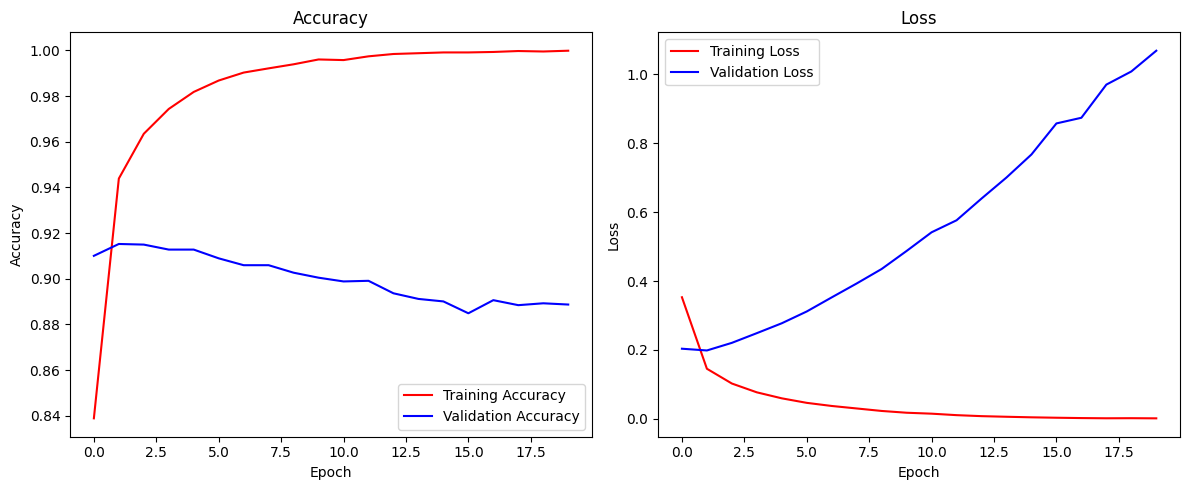

In [82]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="red")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  
plt.show()

In [83]:
# Evaluation :
y_transformer = transformer_model.predict(X_test)
y_transformer = (y_transformer > 0.5).astype(int)

115/115 [==============================] - 0s 1ms/step


In [84]:
accuracy_score(y_test, y_transformer)

0.8887065901011758

In [85]:
confusion_matrix(y_test,y_transformer)

array([[1832,  250],
       [ 157, 1418]], dtype=int64)

In [86]:
print(classification_report(y_test, y_transformer))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2082
           1       0.85      0.90      0.87      1575

    accuracy                           0.89      3657
   macro avg       0.89      0.89      0.89      3657
weighted avg       0.89      0.89      0.89      3657

